In [64]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [66]:
! cp kaggle.json ~/.kaggle/

In [67]:
! chmod 600 ~/.kaggle/kaggle.json

In [68]:
! kaggle datasets download vipoooool/new-plant-diseases-dataset

new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [69]:
!unzip new*

unzip:  cannot find or open new plant diseases dataset(augmented), new plant diseases dataset(augmented).zip or new plant diseases dataset(augmented).ZIP.


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [71]:
len(os.listdir("/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"))

38

In [72]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [73]:
train = train_datagen.flow_from_directory(directory="/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train", target_size=(256,256), batch_size=32)

val = val_datagen.flow_from_directory(directory="/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid", target_size=(256,256), batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


MODEL BUILDING

In [74]:
from keras.layers import Dense, Flatten
from keras.models import Model
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [75]:
base_model = VGG16(input_shape=(256, 256, 3), include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [76]:
for layer in base_model.layers:
  layer.trainable=False

In [77]:
X = Flatten()(base_model.output)

X = Dense(units=38, activation='softmax')(X)

model = Model(base_model.input, X)

In [78]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [79]:
model.compile(optimizer='adam', loss = keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [80]:
#early stopping and model checkpoint

from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1)

#model checkpoint
mc = ModelCheckpoint(filepath = "best_model.h5", min_delta = 0.01, patience = 3, verbose = 1, save_best_onlu = True)

cb = [es, mc]

In [81]:
his = model.fit_generator(train, steps_per_epoch=16, epochs = 50, verbose = 1, callbacks = cb, validation_data=val, validation_steps=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 28.7663 - accuracy: 0.1680
Epoch 1: saving model to best_model.h5
16/16 [==============================] - 18s 1s/step - loss: 28.7663 - accuracy: 0.1680 - val_loss: 20.7280 - val_accuracy: 0.3457
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 15.7329 - accuracy: 0.4375
Epoch 2: saving model to best_model.h5
16/16 [==============================] - 12s 762ms/step - loss: 15.7329 - accuracy: 0.4375 - val_loss: 9.3191 - val_accuracy: 0.6094
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 12.4341 - accuracy: 0.5273
Epoch 3: saving model to best_model.h5
16/16 [==============================] - 12s 757ms/step - loss: 12.4341 - accuracy: 0.5273 - val_loss: 7.2141 - val_accuracy: 0.6836
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 11.0908 - accuracy: 0.6035
Epoch 4: saving model to best_model.h5
16/16 [==============================] - 12s 754ms/step - loss: 11.

In [82]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

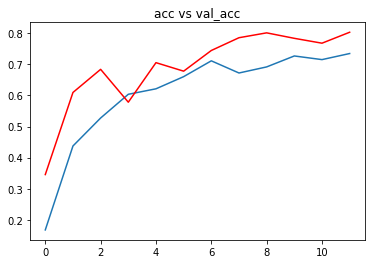

In [83]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs val_acc")
plt.show()

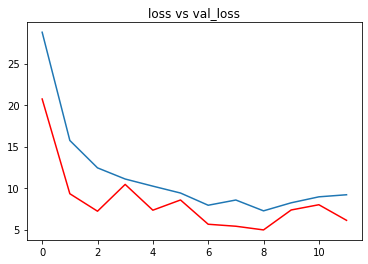

In [84]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs val_loss")
plt.show()

In [85]:
#load best model

from keras.models import load_model

model = load_model("/content/best_model.h5")

In [86]:
acc = model.evaluate_generator(val)[1]

print(f"The accuracy of your model is = {acc*100} %")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of your model is = 79.34213280677795 %


In [87]:
ref = dict(zip( list(train.class_indices.values()), list(train.class_indices.keys())) )

In [88]:
def prediction(path):

  img = load_img(path, target_size = (256,256))
  plt.imshow(img)

  i = img_to_array(img)

  im = preprocess_input(i)

  img = np.expand_dims(im, axis = 0)

  pred = np.argmax(model.predict(img))

  print(f" the image belongs to { ref[pred] } ")

 the image belongs to Apple___Cedar_apple_rust 


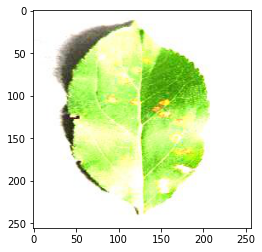

In [97]:
path = "/content/test/test/AppleCedarRust1.JPG"

prediction(path)